# Предсказание автомобиля марки Ford по VIN-коду с применением регулярных выражений

VIN-код или Идентификационный номер транспортного средства - это уникальный код транспортного средства, состоящий из 17 знаков. В коде представлены сведения о производителе и характеристиках транспортного средства, а также о годе выпуска. Строение кода основано на стандартах ISO 3779-1983 и ISO 3780.

|Столбец 1|Столбец 2|Столбец 3|
|-|--------|---|
|Длинная запись в первом столбце|Запись в столбце 2|Запись в столбце 3|
|Кртк зпс| |Слева нет записи|

In [45]:
#pip install xgboost

In [34]:
import re

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import xgboost
from xgboost import XGBRegressor

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.metrics import make_scorer, mean_absolute_percentage_error, mean_squared_error

import shap

In [2]:
ALLOWED_CHARS = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ('I', 'O', 'Q')]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [3]:
wmi = f'(?P<wmi>[{allowed}]{{3}})'
restraint = f'(?P<restraint>[{allowed}])'
model = f'(?P<model>[{allowed}]{{3}})'
engine = f'(?P<engine>[{allowed}])'
check = f'(?P<check>[{allowed}])'
year = f'(?P<year>[{allowed}])'
plant = f'(?P<plant>[{allowed}])'
vis = f'(?P<vis>[{allowed}]{{3}}\\d{{3}})'

VIN = f'{wmi}{restraint}{model}{engine}{check}{year}{plant}{vis}'
PRICE = r'(?P<price>\d+)'

In [4]:
with open('vin_ford_train.txt', 'r', encoding='utf-8') as f:
    content = f.read()
    
content[:250]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZ'

Формат данных VIN:PRICE

In [5]:
data = re.compile(f'\\[{VIN}:{PRICE}\\]')
data

re.compile(r'\[(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<restraint>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\d{3}):(?P<price>\d+)\]',
           re.UNICODE)

In [6]:
values = []
for obj in data.finditer(content):
    values.append(obj.groupdict())

values[:1]

[{'wmi': '2FM',
  'restraint': 'D',
  'model': 'K3J',
  'engine': 'C',
  'check': '4',
  'year': 'B',
  'plant': 'B',
  'vis': 'A41556',
  'price': '12500'}]

Поиск невалидных объектов

In [7]:
valid_vin = r'(\w{14}\d{3})'
valid_price = r'(\d+)'

invalid_vin = r'(?!\w{14}\d{3})(\w+)'
invalid_prcie = r'(?!\d+)(\w+)'

invalid_variance = [
    f'\\[{invalid_vin}:{invalid_prcie}\\]',
    f'\\[{valid_vin}:{invalid_prcie}\\]',
    f'\\[{invalid_vin}:{valid_price}\\]',
]

invalid_pattern = re.compile('(?P<invalid_data>' + '|'.join(invalid_variance) + ')')

invalid_values = []
for obj in invalid_pattern.finditer(content):
    invalid_values.append(obj.groupdict())
    
invalid_values

[{'invalid_data': '[1FM5K8D83DGB91002:XXXX]'},
 {'invalid_data': '[1FM5K8D83DGB9100X:26600]'}]

Создание датасета

In [8]:
data_ford = pd.DataFrame(values)

Напишем функцию для "чекинга" полученного датафрейма

In [10]:
def check(data):
    display(data.head(10))
    print('-----------------')
    display(data.info())
    print('-----------------')
    display(data.describe())

Посмотрим на полученный датафрейм

In [56]:
check(data_ford)

,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600
5,1FM,5,K8D,8,2,D,G,A16143,26400
6,1FT,F,W1C,F,X,C,F,C23663,14000
7,2FM,D,K3J,C,6,C,B,A90002,19500
8,1FT,F,W1C,T,8,D,K,D06233,24400
9,1FM,Z,U64,W,1,3,U,C28949,2900


-----------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   wmi        71884 non-null  object
 1   restraint  71884 non-null  object
 2   model      71884 non-null  object
 3   engine     71884 non-null  object
 4   check      71884 non-null  object
 5   year       71884 non-null  object
 6   plant      71884 non-null  object
 7   vis        71884 non-null  object
 8   price      71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


None

-----------------


,wmi,restraint,model,engine,check,year,plant,vis,price
count,71884,71884,71884,71884,71884,71884,71884,71884,71884
unique,14,26,365,32,11,25,21,68215,643
top,1FM,D,P0H,2,1,D,R,B55197,11000
freq,18347,12370,6171,7015,6622,17286,10535,4,574


In [11]:
data_ford['price'] = data_ford['price'].astype(int)

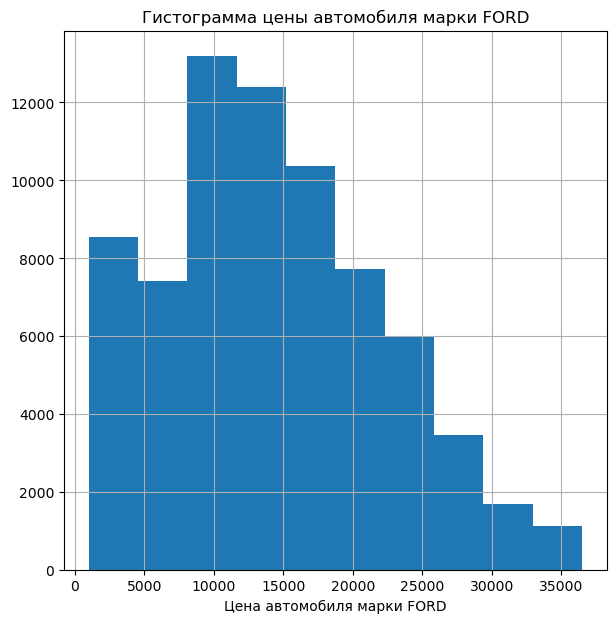

In [42]:
data_ford['price'].hist(figsize=(7,7))
plt.xlabel('Цена автомобиля марки FORD')
plt.title('Гистограмма цены автомобиля марки FORD')
plt.show()

Подготовка данных к обучению

In [13]:
features = data_ford.drop(['check', 'vis', 'price'], axis=1).astype('category')
target = data_ford['price']

In [15]:
print(features.shape, target.shape)

(71884, 6) (71884,)


Модель XGBRegressor

In [16]:
scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']

In [17]:
xgbr = XGBRegressor(enable_categorical=True) 
parameters = [{'n_estimators':[100, 200], 'random_state':[12345], 'max_depth':[5,6,7]}]

gscv = GridSearchCV(xgbr, parameters, scoring=scoring,
                    cv=2, n_jobs=5, refit='neg_root_mean_squared_error', return_train_score=True)
gscv.fit(features, target)


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=True, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid=[{'max_depth': [5, 6, 7], 'n_estimators': [100, 200],
                          'random_state': [12345]}],
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['neg_root_mean_squared_error',
                      'neg_mean_absolute_percentage_error'])

In [18]:
print("Наилучшие параметры модели:")
print(gscv.best_params_)
print("Наилучшее значение RMSE:")
print(-gscv.best_score_)
print("Наилучшее значение MAPE:")
print(gscv.cv_results_['mean_test_neg_mean_absolute_percentage_error'][gscv.best_index_])


Наилучшие параметры модели:
{'max_depth': 5, 'n_estimators': 100, 'random_state': 12345}
Наилучшее значение RMSE:
2782.853224289276
Наилучшее значение MAPE:
-0.20129080162501706


In [19]:
cv = cross_validate(DummyRegressor(), features, target, scoring='neg_root_mean_squared_error')
print('RMSE', -cv['test_score'].mean().round(4))

RMSE 7826.9843


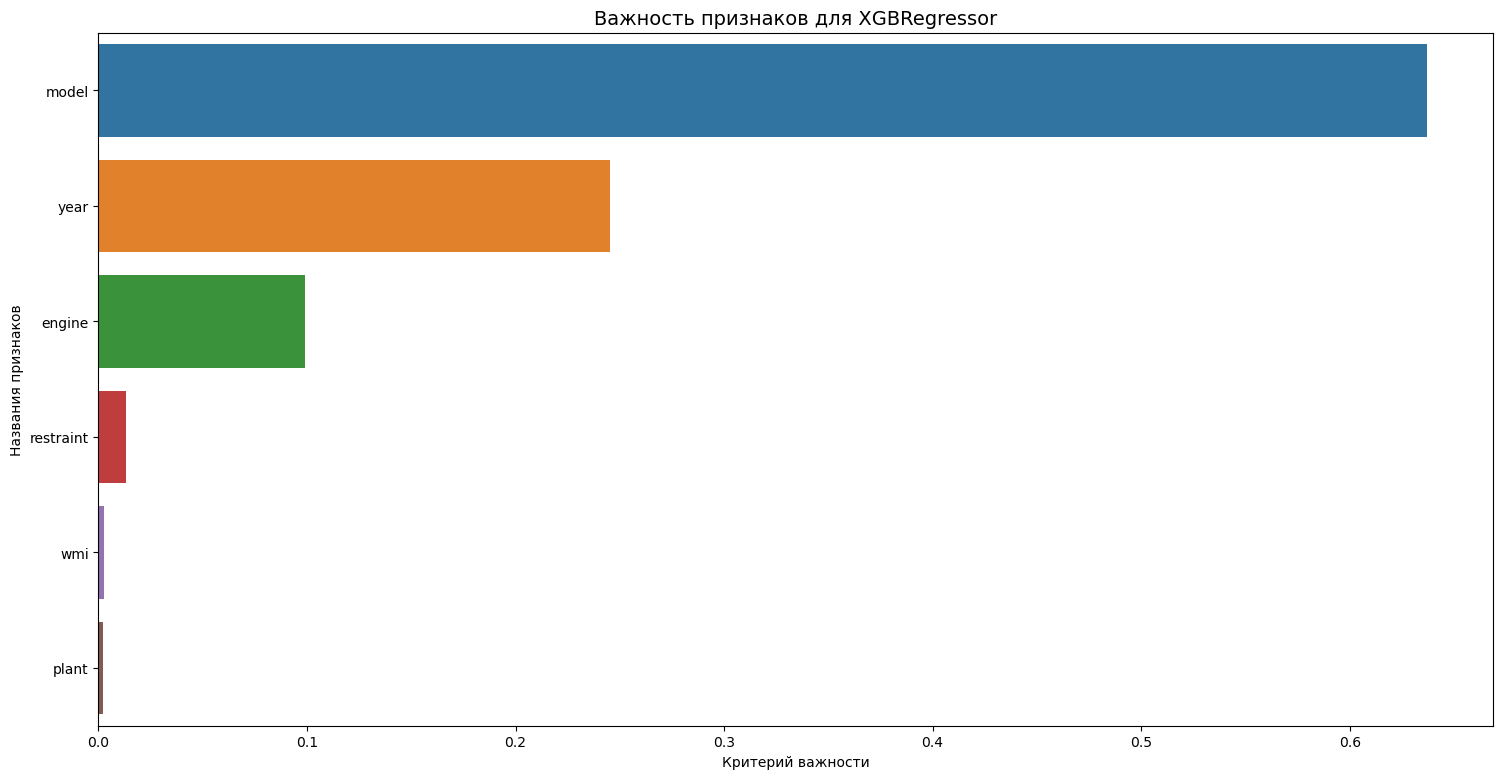

In [25]:
plot_data = {
    'features': features.columns,
    'feature_importances': xgbr.feature_importances_,
}
plot_data = pd.DataFrame(plot_data)
plot_data.sort_values(by='feature_importances', ascending=False, inplace=True)
plt.figure(figsize=(18, 9))
sns.barplot(x=plot_data['feature_importances'], y=plot_data['features'])
plt.title('Важность признаков для XGBRegressor', fontsize=14)
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()